# FISHFactor demo

Using simulated data

In [1]:
import torch
import matplotlib.pyplot as plt
from src.simulation import simulate_data
from src.fishfactor import FISHFactor

In [16]:
# simulation

n_cells = 5
n_genes = 20
n_factors = 3

intensity_scales = torch.distributions.LogNormal(5, 0.1).sample([n_cells, n_genes])

data = simulate_data(
    n_cells=n_cells,
    n_genes=n_genes,
    n_factors=n_factors,
    factor_images_dir='data/simulated/factors',
    intensity_scales=intensity_scales,
    weight_sparsity=0.7
    )

In [17]:
data['coordinates']

,x,y,gene,cell
0,0.555667,0.694735,CIex,0
1,0.390237,0.763076,CIex,0
2,0.551487,0.653719,CIex,0
3,0.963170,0.547980,CIex,0
4,0.241307,0.096368,CIex,0
...,...,...,...,...
25,0.089749,0.554774,usta,4
26,0.052033,0.101821,usta,4
27,0.359525,0.542564,usta,4
28,0.008865,0.663287,usta,4


In [18]:
# model

#device = 'cpu'
device = 'cuda:0'

model = FISHFactor(
    data=data['coordinates'],
    n_factors=n_factors,
    device=device,
)

In [19]:
# training

model.inference()

epoch: 0, cell: 0, improvement: -0.0039, patience: 100
epoch: 0, cell: 1, improvement: -0.0004, patience: 100
epoch: 0, cell: 2, improvement: 0.0026, patience: 100
epoch: 0, cell: 3, improvement: 0.0102, patience: 100
epoch: 0, cell: 4, improvement: -0.0022, patience: 100
epoch: 1, cell: 0, improvement: 0.0037, patience: 99
epoch: 1, cell: 1, improvement: 0.0074, patience: 99
epoch: 1, cell: 2, improvement: -0.002, patience: 99
epoch: 1, cell: 3, improvement: 0.0118, patience: 99
epoch: 1, cell: 4, improvement: 0.0027, patience: 99
epoch: 2, cell: 0, improvement: 0.0105, patience: 98
epoch: 2, cell: 1, improvement: 0.0146, patience: 98
epoch: 2, cell: 2, improvement: 0.0016, patience: 98
epoch: 2, cell: 3, improvement: 0.0144, patience: 98
epoch: 2, cell: 4, improvement: 0.0175, patience: 98
epoch: 3, cell: 0, improvement: 0.0148, patience: 97
epoch: 3, cell: 1, improvement: 0.0129, patience: 97
epoch: 3, cell: 2, improvement: 0.0064, patience: 97
epoch: 3, cell: 3, improvement: 0.0228

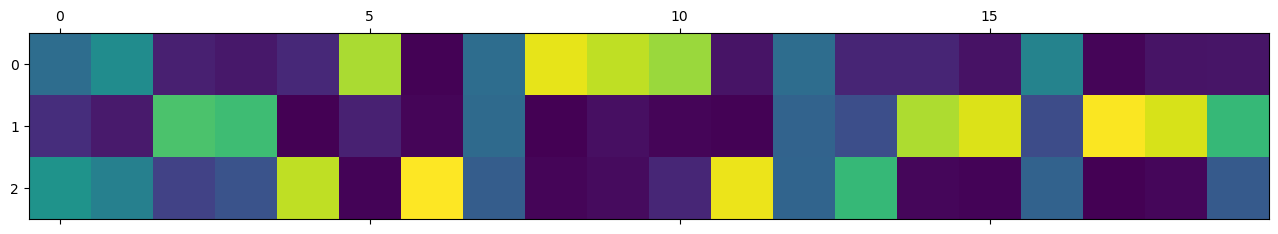

In [20]:
w = model.get_weights()

plt.matshow(w.T)

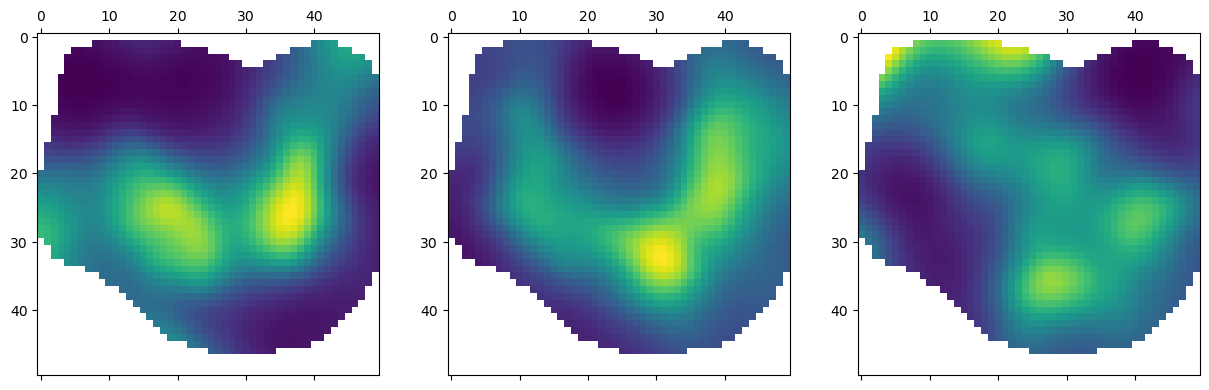

In [21]:
z = model.get_factors()

cell = 0

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for k in range(3):
    axs[k].matshow(z[cell, k])
